<a href="https://colab.research.google.com/github/13Aluminium/RESEARCH/blob/main/0_th_SANSKRIT_OCR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import torch
print(f"GPU available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU name: {torch.cuda.get_device_name(0)}")
    print(f"GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")



GPU available: True
GPU name: Tesla T4
GPU memory: 15.83 GB


In [5]:
!pip install -q rfdetr
!pip install -q supervision
!pip install -q pycocotools


In [6]:
DATASET_PATH = '/content/drive/MyDrive/OCR'  # Will be updated after dataset upload
OUTPUT_PATH = '/content/drive/MyDrive/OCR/results'

In [7]:
import os
# Create output directory if it doesn't exist
!mkdir -p {OUTPUT_PATH}

In [8]:
from google.colab import files
import shutil
import os



# Verify the dataset structure
print("\nDataset structure:")
!ls -la {DATASET_PATH}

# Check for the COCO annotation files
print("\nLooking for COCO annotation files:")
!find {DATASET_PATH} -name "*annotations*.json"




Dataset structure:
total 24
drwx------ 2 root root 4096 May  8 07:22 .ipynb_checkpoints
drwx------ 2 root root 4096 May  8 07:44 model
drwx------ 3 root root 4096 May  8 07:35 results
drwx------ 2 root root 4096 May  8 06:47 test
drwx------ 2 root root 4096 May  8 06:47 train
drwx------ 2 root root 4096 May  8 06:47 valid

Looking for COCO annotation files:
/content/drive/MyDrive/OCR/train/_annotations.coco.json
/content/drive/MyDrive/OCR/test/_annotations.coco.json
/content/drive/MyDrive/OCR/valid/_annotations.coco.json


In [9]:
"""
## Examine COCO Annotations
Let's examine the COCO annotation format to ensure it's correct
"""
import json
import os

# Find annotation files
annotation_files = []
for root, _, files in os.walk(DATASET_PATH):
    for file in files:
        if file.endswith('.json') and 'annotations' in file:
            annotation_files.append(os.path.join(root, file))

if annotation_files:
    for annotation_file in annotation_files:
        print(f"Analyzing annotation file: {annotation_file}")
        try:
            with open(annotation_file, 'r') as f:
                annotations = json.load(f)

            print(f"Keys in annotation file: {annotations.keys()}")
            if 'categories' in annotations:
                print(f"Number of categories: {len(annotations['categories'])}")
                print("Categories:")
                for category in annotations['categories']:
                    print(f"  - ID: {category['id']}, Name: {category.get('name', 'unnamed')}")

            if 'images' in annotations:
                print(f"Number of images: {len(annotations['images'])}")

            if 'annotations' in annotations:
                print(f"Number of annotations: {len(annotations['annotations'])}")

        except Exception as e:
            print(f"Error reading annotation file: {e}")
else:
    print("No COCO annotation files found. Please ensure your dataset contains proper COCO annotations.")


Analyzing annotation file: /content/drive/MyDrive/OCR/train/_annotations.coco.json
Keys in annotation file: dict_keys(['info', 'licenses', 'categories', 'images', 'annotations'])
Number of categories: 3
Categories:
  - ID: 0, Name: UI
  - ID: 1, Name: NO-SHLOK
  - ID: 2, Name: SHLOK
Number of images: 98
Number of annotations: 827
Analyzing annotation file: /content/drive/MyDrive/OCR/test/_annotations.coco.json
Keys in annotation file: dict_keys(['info', 'licenses', 'categories', 'images', 'annotations'])
Number of categories: 3
Categories:
  - ID: 0, Name: UI
  - ID: 1, Name: NO-SHLOK
  - ID: 2, Name: SHLOK
Number of images: 5
Number of annotations: 43
Analyzing annotation file: /content/drive/MyDrive/OCR/valid/_annotations.coco.json
Keys in annotation file: dict_keys(['info', 'licenses', 'categories', 'images', 'annotations'])
Number of categories: 3
Categories:
  - ID: 0, Name: UI
  - ID: 1, Name: NO-SHLOK
  - ID: 2, Name: SHLOK
Number of images: 2
Number of annotations: 15


In [10]:
"""
## Finetune RF-DETR Model
Now let's finetune the model on our dataset
"""
from rfdetr import RFDETRBase
import time

# Initialize the model
model = RFDETRBase()

# Training parameters
EPOCHS = 15
BATCH_SIZE = 4
GRAD_ACCUM_STEPS = 4
LEARNING_RATE = 1e-4

print(f"Starting training with the following parameters:")
print(f"Dataset path: {DATASET_PATH}")
print(f"Output path: {OUTPUT_PATH}")
print(f"Epochs: {EPOCHS}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Gradient accumulation steps: {GRAD_ACCUM_STEPS}")
print(f"Learning rate: {LEARNING_RATE}")

# Start training
start_time = time.time()
model.train(
    dataset_dir=DATASET_PATH,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    grad_accum_steps=GRAD_ACCUM_STEPS,
    lr=LEARNING_RATE,
    output_dir=OUTPUT_PATH,

)
training_time = time.time() - start_time
print(f"Training completed in {training_time/60:.2f} minutes")


Loading pretrain weights


reinitializing your detection head with 3 classes.


Starting training with the following parameters:
Dataset path: /content/drive/MyDrive/OCR
Output path: /content/drive/MyDrive/OCR/results
Epochs: 15
Batch size: 4
Gradient accumulation steps: 4
Learning rate: 0.0001
TensorBoard logging initialized. To monitor logs, use 'tensorboard --logdir /content/drive/MyDrive/OCR/results' and open http://localhost:6006/ in browser.
Not using distributed mode
git:
  sha: N/A, status: clean, branch: N/A

Namespace(num_classes=3, grad_accum_steps=4, amp=True, lr=0.0001, lr_encoder=0.00015, batch_size=4, weight_decay=0.0001, epochs=15, lr_drop=100, clip_max_norm=0.1, lr_vit_layer_decay=0.8, lr_component_decay=0.7, do_benchmark=False, dropout=0, drop_path=0.0, drop_mode='standard', drop_schedule='constant', cutoff_epoch=0, pretrained_encoder=None, pretrain_weights='rf-detr-base.pth', pretrain_exclude_keys=None, pretrain_keys_modify_to_load=None, pretrained_distiller=None, encoder='dinov2_windowed_small', vit_encoder_num_layers=12, window_block_indexes=N

Epoch: [0]  [0/6]  eta: 0:01:30  lr: 0.000100  class_error: 36.13  loss: 22.7914 (22.7914)  loss_ce: 0.5440 (0.5440)  loss_bbox: 3.2484 (3.2484)  loss_giou: 1.8452 (1.8452)  loss_ce_0: 0.4948 (0.4948)  loss_bbox_0: 3.4191 (3.4191)  loss_giou_0: 1.9217 (1.9217)  loss_ce_1: 0.5238 (0.5238)  loss_bbox_1: 3.3058 (3.3058)  loss_giou_1: 1.8578 (1.8578)  loss_ce_enc: 0.5147 (0.5147)  loss_bbox_enc: 3.2189 (3.2189)  loss_giou_enc: 1.8972 (1.8972)  loss_ce_unscaled: 0.5440 (0.5440)  class_error_unscaled: 36.1305 (36.1305)  loss_bbox_unscaled: 0.6497 (0.6497)  loss_giou_unscaled: 0.9226 (0.9226)  cardinality_error_unscaled: 1708.2500 (1708.2500)  loss_ce_0_unscaled: 0.4948 (0.4948)  loss_bbox_0_unscaled: 0.6838 (0.6838)  loss_giou_0_unscaled: 0.9609 (0.9609)  cardinality_error_0_unscaled: 2148.0000 (2148.0000)  loss_ce_1_unscaled: 0.5238 (0.5238)  loss_bbox_1_unscaled: 0.6612 (0.6612)  loss_giou_1_unscaled: 0.9289 (0.9289)  cardinality_error_1_unscaled: 383.0000 (383.0000)  loss_ce_enc_unscaled:

In [12]:
model_checkpoint_path = f"{OUTPUT_PATH}/checkpoint.pth"
if os.path.exists(model_checkpoint_path):
    print(f"Loading model checkpoint from {model_checkpoint_path}")
    export_model = RFDETRBase(pretrain_weights=model_checkpoint_path)

    # Export the model
    export_model.export(output_dir=OUTPUT_PATH)
    print(f"Model exported to {OUTPUT_PATH}")

    # Save the trained model to Google Drive for future use
    DRIVE_OUTPUT_PATH = '/content/drive/MyDrive/OCR/model'  # Changed to match your path
    !mkdir -p {DRIVE_OUTPUT_PATH}
    !cp -r {OUTPUT_PATH}/* {DRIVE_OUTPUT_PATH}/
    print(f"Model saved to Google Drive at {DRIVE_OUTPUT_PATH}")
else:
    print(f"Error: Model checkpoint not found at {model_checkpoint_path}")
    print("Make sure training completed successfully before exporting")



Loading model checkpoint from /content/drive/MyDrive/OCR/results/checkpoint.pth
Loading pretrain weights


reinitializing detection head with 2 classes


Exporting model to ONNX format


Installing onnxruntime by `/usr/bin/python3 -m pip install onnxruntime`, please wait for a moment..

PyTorch inference output shapes - Boxes: torch.Size([1, 3900, 4]), Labels: torch.Size([1, 3900, 3])



Successfully exported ONNX model: /content/drive/MyDrive/OCR/results/inference_model.onnx
Successfully exported ONNX model to: /content/drive/MyDrive/OCR/results/inference_model.onnx
ONNX export completed successfully
Model exported to /content/drive/MyDrive/OCR/results
Model saved to Google Drive at /content/drive/MyDrive/OCR/model


Please upload an image for inference...


Saving page_5.png to page_5 (1).png
Running inference on page_5 (1).png
Loading image from path: page_5 (1).png
Loading pretrain weights


reinitializing detection head with 2 classes


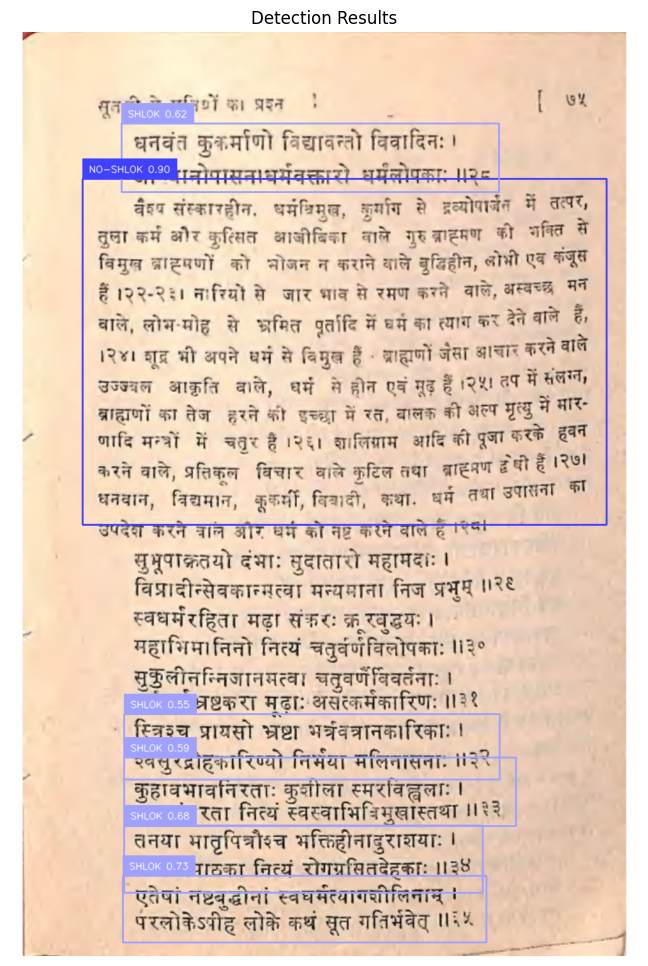

Found 6 objects
  1. NO-SHLOK: 0.90
  2. SHLOK: 0.73
  3. SHLOK: 0.68
  4. SHLOK: 0.62
  5. SHLOK: 0.59
  6. SHLOK: 0.55


Detections(xyxy=array([[ 115.28542,  233.5899 ,  948.9385 ,  783.0171 ],
       [ 179.40903, 1341.113  ,  757.33514, 1447.3152 ],
       [ 181.32823, 1261.8435 ,  751.25555, 1368.6234 ],
       [ 177.64247,  145.95021,  777.28394,  254.7831 ],
       [ 181.46724, 1153.5599 ,  804.9313 , 1262.776  ],
       [ 181.76007, 1084.0374 ,  778.7101 , 1188.9617 ]], dtype=float32), mask=None, confidence=array([0.90147996, 0.7329528 , 0.68027395, 0.6199212 , 0.5865057 ,
       0.55203986], dtype=float32), class_id=array([1, 2, 2, 2, 2, 2]), tracker_id=None, data={}, metadata={})

In [15]:
"""
## Inference Using Custom Images
Let's create a function to run inference on custom images
"""
from google.colab import files
import io
import supervision as sv
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

def run_inference_on_custom_image():
    # Define the inference function inside here to avoid scope issues
    def inference_on_image(image_path):
        print(f"Loading image from path: {image_path}")
        image = Image.open(image_path)

        # Load the model if not already loaded
        model_checkpoint_path = f"{OUTPUT_PATH}/checkpoint.pth"
        if os.path.exists(model_checkpoint_path):
            inference_model = RFDETRBase(pretrain_weights=model_checkpoint_path)
        else:
            print(f"Model checkpoint not found at {model_checkpoint_path}, using base model")
            inference_model = RFDETRBase()

        # Make prediction
        detections = inference_model.predict(image, threshold=0.5)

        # Try to get category names from annotation file
        try:
            # Find annotation files if not already defined
            annotation_file = None
            for root, _, files in os.walk(DATASET_PATH):
                for file in files:
                    if file.endswith('.json') and 'annotations' in file:
                        annotation_file = os.path.join(root, file)
                        break
                if annotation_file:
                    break

            # Get category names
            if annotation_file:
                with open(annotation_file, 'r') as f:
                    annotations = json.load(f)

                category_id_to_name = {cat['id']: cat['name'] for cat in annotations['categories']}

                # Create labels
                labels = [
                    f"{category_id_to_name.get(class_id, f'Class {class_id}')} {confidence:.2f}"
                    for class_id, confidence
                    in zip(detections.class_id, detections.confidence)
                ]
            else:
                raise FileNotFoundError("No annotation file found")
        except:
            # Fallback to default labels
            labels = [
                f"Class {class_id} {confidence:.2f}"
                for class_id, confidence
                in zip(detections.class_id, detections.confidence)
            ]

        # Annotate and display the image
        annotated_image = np.array(image.copy())
        annotated_image = sv.BoxAnnotator().annotate(annotated_image, detections)
        annotated_image = sv.LabelAnnotator().annotate(annotated_image, detections, labels)

        plt.figure(figsize=(12, 12))
        plt.imshow(annotated_image)
        plt.axis('off')
        plt.title("Detection Results")
        plt.show()

        print(f"Found {len(detections)} objects")
        for i, (class_id, confidence) in enumerate(zip(detections.class_id, detections.confidence)):
            class_name = category_id_to_name.get(class_id, f'Class {class_id}') if 'category_id_to_name' in locals() else f'Class {class_id}'
            print(f"  {i+1}. {class_name}: {confidence:.2f}")

        return detections

    # Upload and process image
    print("Please upload an image for inference...")
    uploaded = files.upload()

    if len(uploaded) > 0:
        image_file = list(uploaded.keys())[0]

        # Run inference
        print(f"Running inference on {image_file}")
        detections = inference_on_image(image_file)
        return detections
    else:
        print("No image uploaded")
        return None

# Run inference on a custom image
run_inference_on_custom_image()


reinitializing detection head with 2 classes


Running inference with confidence threshold: 0.30


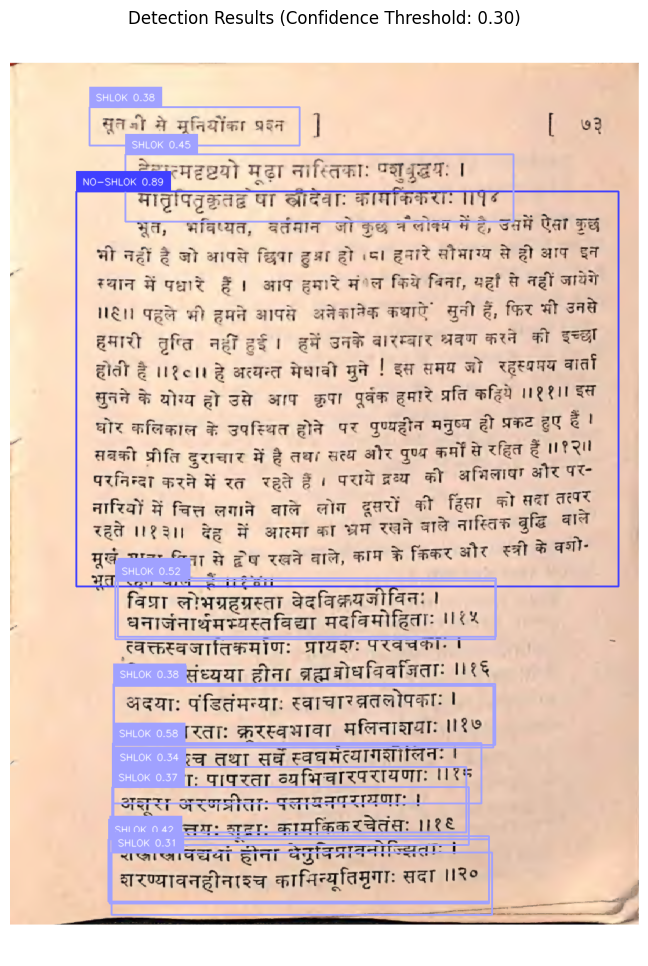

Found 13 objects with confidence threshold 0.30
  1. NO-SHLOK: 0.89
  2. SHLOK: 0.70
  3. SHLOK: 0.66
  4. SHLOK: 0.65
  5. SHLOK: 0.58
  6. SHLOK: 0.52
  7. SHLOK: 0.45
  8. SHLOK: 0.42
  9. SHLOK: 0.38
  10. SHLOK: 0.38
  11. SHLOK: 0.37
  12. SHLOK: 0.34
  13. SHLOK: 0.31


FloatSlider(value=0.45, continuous_update=False, description='Confidence:', layout=Layout(width='50%'), max=0.…

Button(description='Rerun with new threshold', disabled=True, icon='refresh', style=ButtonStyle(), tooltip='Cl…

Please upload an image for inference...


Saving page_3.png to page_3 (3).png
Running initial inference on page_3 (3).png
Loading image from path: page_3 (3).png
Loading pretrain weights


reinitializing detection head with 2 classes


Running inference with confidence threshold: 0.45


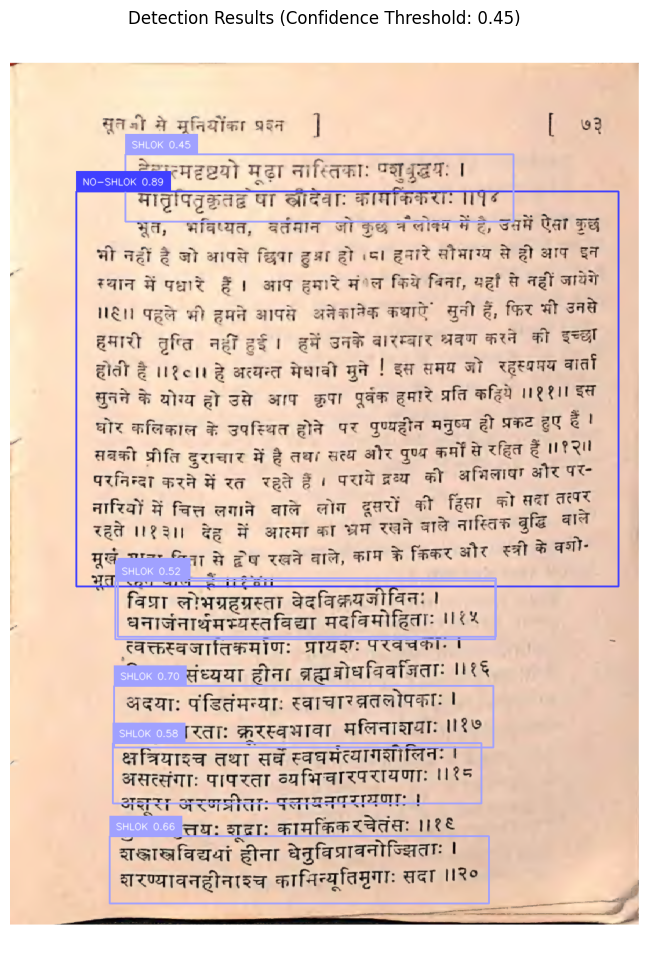

Found 7 objects with confidence threshold 0.45
  1. NO-SHLOK: 0.89
  2. SHLOK: 0.70
  3. SHLOK: 0.66
  4. SHLOK: 0.65
  5. SHLOK: 0.58
  6. SHLOK: 0.52
  7. SHLOK: 0.45

You can adjust the confidence threshold with the slider above and click 'Rerun' to see updated results


Detections(xyxy=array([[ 105.9224 ,  253.01907,  967.20294,  881.0057 ],
       [ 165.99936, 1039.8474 ,  768.2456 , 1137.4844 ],
       [ 158.13228, 1278.5737 ,  761.8431 , 1385.6451 ],
       [ 171.11572,  868.32007,  772.83826,  961.09467],
       [ 163.06439, 1130.6749 ,  749.47906, 1226.0933 ],
       [ 167.83562,  872.4531 ,  771.2916 ,  965.9494 ],
       [ 183.96384,  194.88107,  800.3706 ,  301.3768 ]], dtype=float32), mask=None, confidence=array([0.8881047 , 0.70320266, 0.65856934, 0.6526053 , 0.5807849 ,
       0.5222306 , 0.45402816], dtype=float32), class_id=array([1, 2, 2, 2, 2, 2, 2]), tracker_id=None, data={}, metadata={})

In [21]:
from google.colab import files
import io
import supervision as sv
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from IPython.display import display

def run_inference_on_custom_image(default_threshold=0.3):
    # Create UI elements for confidence threshold
    threshold_slider = widgets.FloatSlider(
        value=default_threshold,
        min=0.1,
        max=0.9,
        step=0.05,
        description='Confidence:',
        disabled=False,
        continuous_update=False,
        orientation='horizontal',
        readout=True,
        readout_format='.2f',
        layout=widgets.Layout(width='50%')
    )

    # Define the inference function
    def inference_on_image(image_path, confidence_threshold):
        print(f"Loading image from path: {image_path}")
        image = Image.open(image_path)

        # Load the model if not already loaded
        model_checkpoint_path = f"{OUTPUT_PATH}/checkpoint.pth"
        if os.path.exists(model_checkpoint_path):
            inference_model = RFDETRBase(pretrain_weights=model_checkpoint_path)
        else:
            print(f"Model checkpoint not found at {model_checkpoint_path}, using base model")
            inference_model = RFDETRBase()

        # Make prediction with user-specified threshold
        print(f"Running inference with confidence threshold: {confidence_threshold:.2f}")
        detections = inference_model.predict(image, threshold=confidence_threshold)

        # Try to get category names from annotation file
        try:
            # Find annotation files if not already defined
            annotation_file = None
            for root, _, files in os.walk(DATASET_PATH):
                for file in files:
                    if file.endswith('.json') and 'annotations' in file:
                        annotation_file = os.path.join(root, file)
                        break
                if annotation_file:
                    break

            # Get category names
            if annotation_file:
                with open(annotation_file, 'r') as f:
                    annotations = json.load(f)

                category_id_to_name = {cat['id']: cat['name'] for cat in annotations['categories']}

                # Create labels
                labels = [
                    f"{category_id_to_name.get(class_id, f'Class {class_id}')} {confidence:.2f}"
                    for class_id, confidence
                    in zip(detections.class_id, detections.confidence)
                ]
            else:
                raise FileNotFoundError("No annotation file found")
        except:
            # Fallback to default labels
            labels = [
                f"Class {class_id} {confidence:.2f}"
                for class_id, confidence
                in zip(detections.class_id, detections.confidence)
            ]

        # Annotate and display the image
        annotated_image = np.array(image.copy())
        annotated_image = sv.BoxAnnotator().annotate(annotated_image, detections)
        annotated_image = sv.LabelAnnotator().annotate(annotated_image, detections, labels)

        plt.figure(figsize=(12, 12))
        plt.imshow(annotated_image)
        plt.axis('off')
        plt.title(f"Detection Results (Confidence Threshold: {confidence_threshold:.2f})")
        plt.show()

        print(f"Found {len(detections)} objects with confidence threshold {confidence_threshold:.2f}")
        for i, (class_id, confidence) in enumerate(zip(detections.class_id, detections.confidence)):
            class_name = category_id_to_name.get(class_id, f'Class {class_id}') if 'category_id_to_name' in locals() else f'Class {class_id}'
            print(f"  {i+1}. {class_name}: {confidence:.2f}")

        return detections

    # Create a button for rerunning inference with new threshold
    uploaded_files = {}
    current_image = [None]  # Use a list to store mutable reference

    def on_button_clicked(b):
        if current_image[0]:
            inference_on_image(current_image[0], threshold_slider.value)

    rerun_button = widgets.Button(
        description='Rerun with new threshold',
        disabled=True,
        button_style='',
        tooltip='Click to rerun inference with the selected confidence threshold',
        icon='refresh'
    )
    rerun_button.on_click(on_button_clicked)

    # Display the slider and button
    display(threshold_slider)
    display(rerun_button)

    # Upload and process image
    print("Please upload an image for inference...")
    uploaded = files.upload()

    if len(uploaded) > 0:
        image_file = list(uploaded.keys())[0]
        current_image[0] = image_file  # Store the image path
        uploaded_files.update(uploaded)

        # Enable the rerun button
        rerun_button.disabled = False

        # Run initial inference
        print(f"Running initial inference on {image_file}")
        detections = inference_on_image(image_file, threshold_slider.value)

        print("\nYou can adjust the confidence threshold with the slider above and click 'Rerun' to see updated results")
        return detections
    else:
        print("No image uploaded")
        return None

# Run inference on a custom image with interactive confidence threshold
run_inference_on_custom_image(default_threshold=0.45)
